# Threebody Reaction Example
- at density of $n \sim 10^8 cm^{-3}$, molecular hydrogen begins to form more effectively through the three-body reaction channel, i.e. $$\mathrm{H +H + H \rightarrow H_2 + H}$$ The collapsing gas undergoes a rapid transition from being atomic to almost fully molecular via this process. since this process evolves rapidly, this often poses a challenge to the stability of the solver. Here we investigate in particular this process in detail.

In [7]:
# importing necessary libraries
import pyximport
import numpy as np
import os

from   dengo.chemistry_constants import tiny, kboltz, mh, G
import dengo.primordial_rates
import dengo.primordial_cooling

from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, \
    species_registry
import dengo.primordial_rates
import dengo.primordial_cooling

import sympy
from sympy import lambdify
import matplotlib.pyplot as plt

# Create a simple network
Let's consider only the most significant reactions at high densities, and compare it with the full network with 22 reactions. Similar to the previous example, we have to register our required reactions/ cooling actions, then add reactions to the `dengo.chemical_network.ChemicalNetwork` object. 

\begin{align}
\quad \mathrm{H_2 + H_1} & \mathrm{\rightarrow 3H_1} \\
\quad \mathrm{H_1 + H_1 + H_1} & \mathrm{\rightarrow H_2 + H_1}
\end{align}

In [8]:
# we register the rates predefined in dengo.primordial_rates
# so that they can be imported into our network object
dengo.primordial_rates.setup_primordial()

# create our network and add reactions to it
cn_simple = ChemicalNetwork()
cn_simple.add_reaction("k13")
cn_simple.add_reaction("k22")
cn_simple.add_cooling("h2formation")
cn_simple.init_temperature()

Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1


# Generate templates
With the `ChemicalNetwork` object, `Dengo` can write the C solver.
The corresponding auxillary library paths are needed to be set as the environomental variables, in order to compile our python modules.

- <font color='green'>HDF5_DIR </font>          (HDF5 installation path)
- <font color='green'>CVODE_PATH </font>        (CVode installation path)
- <font color='green'>SUITESPARSE_PATH </font>  (SuiteSparse library which is optional unless we use `KLU` option)
- <font color='green'> DENGO_INSTALL_PATH</font> (Installation Path of Dengo)

`ChemicalNetwork.write_solver` writes serveral files

### Main components that drives `Dengo`

- <font color='blue'>{{solver_name}}_solver.h </font>
- <font color='blue'>{{solver_name}}_solver.C </font>(major modules in Dengo)
- <font color='blue'>{{solver_name}}_solver_main.h </font>
- <font color='blue'>{{solver_name}}_solver_main.C </font>(example script to use the C library) 
- <font color='blue'>initialize_cvode_solver.C </font>(wrapper function for the CVode library)
- <font color='blue'>Makefile </font>(to compile the dengo library `libdengo.a`)

### Helper function to compile `Dengo` C files for `Python` wrapper
- <font color='blue'>{{solver_name}}_solver_run.pyxbld </font>
- <font color='blue'>{{solver_name}}_solver_run.pyxdep </font>
- <font color='blue'>{{solver_name}}_solver_run.pxd </font>
- <font color='blue'>{{solver_name}}_solver_run.pyx </font> (major Python wrapper)

In [9]:
output_dir = "."
solver_name = "simple"
use_omp = True
use_cvode = True
use_suitesparse = True

# specify the library path
os.environ["HDF5_DIR"] = "/home/kwoksun2/anaconda3"
os.environ["CVODE_PATH"] = "/home/kwoksun2/dengo-merge/cvode-3.1.0/instdir"
os.environ["HDF5_PATH"]  = "/home/kwoksun2/anaconda3"
os.environ["SUITESPARSE_PATH"] = "/home/kwoksun2/dengo-merge/suitesparse"
os.environ["DENGO_INSTALL_PATH"] = "/home/kwoksun2/dengo_install"

# write the solver
cn_simple.write_solver(solver_name, output_dir=output_dir,
                solver_template="cv_omp/sundials_CVDls",
                ode_solver_source="initialize_cvode_solver.C")

# install the library
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True, inplace=True)

# load the compile library 
simple_solver_run = pyximport.load_module(
    "{}_solver_run".format(solver_name),
    "{}_solver_run.pyx".format(solver_name),
    build_inplace=True, pyxbuild_dir="_dengo_temp")

You have suitesparse!


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/kwoksun2/dengo-merge/cookbook/simple_solver_run.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)


# Specifying Initial Condition
Our Python wrapper takes the initial condition as a dictionary. We write a handy function to help us generate initial conditions with a few parameters, density, temperature, and mass fraction of molecular hydrogen. Once the abundance of the major species are specified, we can calculate the free electrons `de` with the `ChemicalNetwork.calculate_free_electrons`. 

To calculate thermal energy from density and temperature,
\begin{equation}
\mathrm{ge} = \sum_{i \in \mathrm{species}} \frac{n_i k T}{\gamma_i - 1}
\end{equation}

where $n_i$, $\gamma_i$ are the number density and the specific heat ratios of the $\mathrm{i^{th}}$ species. For some species like molecular hydrogen $H_2$, the specific heat ratio $\gamma_{\mathrm{H_2}}$ is temperature dependent. At low temperature, the molecule behave as if a monoatomic gas which has a $\gamma = 5/3$. As the temperature increases, the available thermal energy is large enough and is then capable of driving the 2 extra rotational degree of freedom.

```python
H2I = species_registry['H2_1']
gammaH2 = cn_simple.species_gamma(H2I, temp=True, name=False)
fgamma = sympy.lambdify("T", gammaH2)
plt.semilogx(cn_simple.T, fgamma(cn_simple.T))
plt.xlabel("Temperature ($\mathrm{K}$)")
plt.ylabel("Specific Heat Ratio ($\gamma_{\mathrm{H_2}}$)")
plt.savefig("gammaH2.png")
```

<p align="center">
  <img src="gammaH2.png" />
</p>

In [10]:
def setup_initial_conditions(network, density, temperature, h2frac, NCELLS):
    # setting initial conditions
    temperature = np.ones((NCELLS))*temperature
    init_array = np.ones(NCELLS) * density
    init_values = dict()
    init_values["H_1"] = init_array * 0.76 * ( 1-h2frac )
    init_values['H_2'] = init_array * tiny
    init_values['H_m0'] = init_array * tiny
    init_values['He_1'] = init_array * 0.24
    init_values['He_2'] = init_array * tiny
    init_values['He_3'] = init_array * tiny
    init_values['H2_1'] = init_array * 0.76 * h2frac
    init_values['H2_2'] = init_array * tiny
    init_values['de'] = init_array * tiny

    # update and calculate electron density and etc with the handy functions
    # init_values = primordial.convert_to_mass_density(init_values)
    init_values['de'] = network.calculate_free_electrons(init_values)
    # init_values['density'] = primordial.calculate_total_density(init_values)
    init_values['density'] = np.ones((NCELLS))*density
    number_density = network.calculate_number_density(init_values)

    # set up initial temperatures values used to define ge
    init_values['T'] = temperature

    # calculate ge (very crudely, no H2 help here)
    gamma = 5.0/3.0
    mH = 1.67e-24
    init_values["ge"] = 3.0 / 2.0 * temperature * kboltz / mH

    return init_values

# Running the Wrapper
Once the initial condition is specified, we can finally solve some chemistry.
`{{solver_name}}_solver_run.run_{{solver}}`
- <font color='blue'> states </font> (initial condition)
- <font color='blue'> dtf </font> (evolved time in seconds)
- <font color='blue'> niter </font> (maximum number of iteration)
- <font color='blue'> reltol </font> (relative tolerance level of the solver; 0.001 => 0.1% level)

`niter` specify somehow the initial timestep $dt = \mathrm{dtf/niter}$. After every succesful integration, the timestep is increased to $1.1 dt$, and the solution is accumulated until the evolution timescale reaches `dtf`. In the following example, we blow up the `niter`, so that we can track the actual evolution of the system with time. 

In [16]:
# Initial Conditions
density = 1e10 # number density
temperature = 1000.0 # K
H2Fraction  = 1.0e-5 # molecular mass fraction
ncells = 1 # number of cells

# freefall timescale
dtf = 10.0/ np.sqrt(G*mh*density)

states =  setup_initial_conditions(cn_simple, density, temperature, H2Fraction, ncells)
rv, rv_int = simple_solver_run.run_simple(states, dtf, niter=1e6, reltol = 1.0e-6)

Successful iteration[    0]: (2.995e+05) 2.995e+05 / 2.995e+11
Successful iteration[  100]: (4.128e+09) 4.540e+10 / 2.995e+11
End in 121 iterations: 2.99536e+11 / 2.99536e+11 (0.00000e+00)


# Let's plot the result!

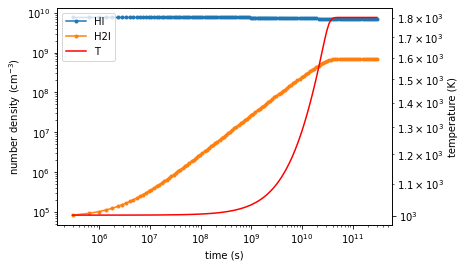

In [17]:
flag = rv_int["successful"]
t    = rv_int["t"][flag]
H2I  = rv_int["H2_1"][0][flag]
HI   = rv_int["H_1"][0][flag]
T    = rv_int['T'][0][flag]

f, ax = plt.subplots(figsize=(6,4))
ax.loglog(t, HI, marker= '.', label='HI')
ax.loglog(t, H2I, marker= '.', label="H2I")
ax.set_xlabel("time (s)")
ax.set_ylabel("number density $(\mathrm{cm^{-3}})$")

ax2 =ax.twinx()
ax2.loglog(t, T, color='r', label='T')
ax2.set_ylabel("temperature (K)")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Equilibrium $\mathrm{H_2}$ fraction
With `Dengo`, we can analytically evaluate the molecular hydrogen fraction with `Sympy`. We can compare and see if it matches up with what we see from the actual evaluation. 

\begin{equation}
\begin{split}
\frac{d \mathrm{H_2}}{dt} &= −k13 ~ \mathrm{H_2 ~ H} +k22 ~ \mathrm{H^3} = 0 \\
\mathrm{H_2} &= \mathrm{\frac{k22 ~ H^2}{k13}}
\end{split}
\end{equation}

We can get the first equation $\frac{d \mathrm{H_2}}{dt}$ from `ChemicalNetwork.species_total("H2_1")`. We can solve the above equation with `sympy.solvers.solve`.

In [18]:
eq = cn_simple.species_total("H2_1")
eq

-k13[i]*H2_1*H_1 + k22[i]*H_1**3

In [19]:
equil_h2 = sympy.solvers.solve(eq, "H2_1")
equil_h2[0]

/home/kwoksun2/anaconda3/lib/python3.8/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.solvers.solvers with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.solvers.solvers instead.
See https://github.com/sympy/sympy/issues/18245 for more info.

  self.Warn(


k22[i]*H_1**2/k13[i]

# Evaluate the Reaction Rates
reaction rates are dependent of temperature, as of now, it is a little tricky to calculate them in dengo, this will be made easier in the later version of dengo

In [20]:
from dengo.chemistry_constants import tevk
class TemperatureClass():
    def __init__(self, T):
        self.T = T
        self.logT = np.log(self.T)
        self.tev = self.T / tevk
        self.logtev = np.log(self.tev)
        self.threebody = 4
        
def get_rate_by_temp(states, species, network):
    T = states["T"]
    # this class can be ingested by dengo functions to obtain corresponding rates
    tc = TemperatureClass(T)
    # reaction rates:
    rates = {}
    for rn, rxn in sorted(network.reactions.items()):
        eq = rxn.species_equation(species)
        if eq == 0: continue
        rates[str(rxn.coeff_sym)] = rxn.coeff_fn(tc)
        print(rxn)
    return rates

def evaluate_expression(states, rates, equation):
    sym_fs = list(equation.free_symbols)    
    sym_arg = []
    for s in sym_fs:
        # drop ge cos this is reaction rate is implicit function of temperature
        if not str(s) == "ge":
            sym_arg.append(s)

    states.update(rates)
    # prepare arguments in correct order to be put into the lambdify equation
    val_arg = []
    for a in sym_arg:
        if str(a) == 'ge': continue
        val_arg.append(states[str(a)])

    # need to lambdify to take arrays as input
    f = lambdify(sym_arg, equation)

    return f(*val_arg)

def evaluate_equilibrium_H2( h1_density, temperature, network):
    
    states = {}
    states["H_1"] = h1_density
    states["T"] = temperature
    rates = get_rate_by_temp(states, "H2_1", network)
    
    eq = network.species_total("H2_1")
    equil_h2 = sympy.solvers.solve(eq, "H2_1")
    if len(equil_h2) > 1:
        equil_h2 = equil_h2[1]
    else:
        equil_h2 = equil_h2[0]
    return evaluate_expression(states, rates, equil_h2)

# Visualize the equilibrium $\mathrm{H_2}$ landscape

k13 : 1*H2_1 + 1*H_1 => 3*H_1
k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1


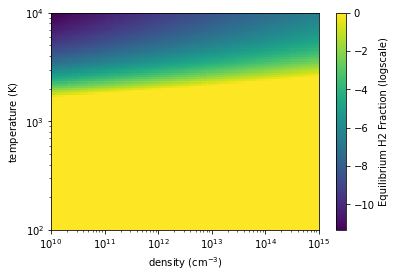

In [21]:
temp_arr = np.logspace(2, 4, 100)
dens_arr = np.logspace(10, 15, 100)
temp2d, dens2d = np.meshgrid(temp_arr, dens_arr)

equilH2_2d = evaluate_equilibrium_H2( dens2d, temp2d, cn_simple)

h2frac = equilH2_2d / dens2d
h2frac[h2frac > 1] = 1.0

plt.pcolormesh( dens2d, temp2d,  np.log10( h2frac ))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("density ($\mathrm{cm^{-3}}$)")
plt.ylabel("temperature ($\mathrm{K}$)")

cbar = plt.colorbar()
cbar.set_label("Equilibrium H2 Fraction (logscale)")

# Let's overlay the equilibrium $H_2$ in the above plot! 

k13 : 1*H2_1 + 1*H_1 => 3*H_1
k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.solvers.solvers with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.solvers.solvers instead.
See https://github.com/sympy/sympy/issues/18245 for more info.

  self.Warn(


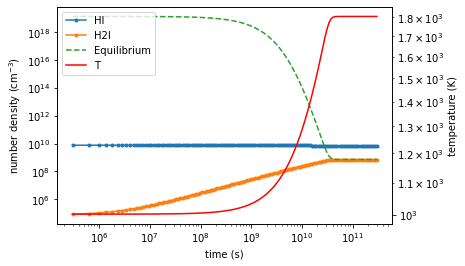

In [22]:
flag = rv_int["successful"]
t    = rv_int["t"][flag]
H2I  = rv_int["H2_1"][0][flag]
HI   = rv_int["H_1"][0][flag]

f, ax = plt.subplots(figsize=(6,4))
ax.loglog(t, HI, marker= '.', label='HI')
ax.loglog(t, H2I, marker= '.', label="H2I")
ax.set_xlabel("time (s)")
ax.set_ylabel("number density $(\mathrm{cm^{-3}})$")

equil_H2 = 2.01588 * evaluate_equilibrium_H2( HI, T, cn_simple )
ax.loglog(t, equil_H2 , ls = '--', label="Equilibrium")

ax2 =ax.twinx()
ax2.loglog(t, T, color='r', label='T')
ax2.set_ylabel("temperature (K)")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# voila! they matches up nicely when the equilibrium is reached!
- this acts as a nice sanity check on both our solver, and our understanding of the network